# DO YOU LIKE OR DISLIKE THIS SONG? KAGGLE DATASET

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.preprocessing import LabelEncoder 

Capture All CSV Files

In [2]:
globbed = glob('*.csv')

In [3]:
globbed

['users.csv',
 'test.csv',
 'words.csv',
 'tracks_mean_benchmark.csv',
 'artists_mean_benchmark.csv',
 'UserKey.csv',
 'train.csv',
 'users_mean_benchmark.csv',
 'global_mean_benchmark.csv']

Convert Files into DataFrames

In [4]:
train_df =pd.read_csv('train.csv')
user_key_df = pd.read_csv('UserKey.csv', sep='delimiter', header=None)
users_df = pd.read_csv('users.csv')

/Users/grayangelo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


# Data Cleaning

In [5]:
unique_train = train_df.drop_duplicates(subset='User', keep='first')

In [6]:
#Rename column
unique_train.rename(columns={'User': 'RESPID'}, inplace=True)

/Users/grayangelo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


CONVERTED ALL RATINGS > 50, 1 RATINGS < 50, 0

In [7]:
unique_train

,Artist,Track,RESPID,Rating,Time
0,40,179,47994,9,17
1,9,23,8575,58,7
2,46,168,45475,13,16
3,11,153,39508,42,15
4,14,32,11565,54,19
...,...,...,...,...,...
188597,17,36,14886,50,8
188629,13,31,12728,9,19
188650,47,170,45708,30,4
188672,47,171,46408,59,4


In [9]:
merged_df = pd.merge(users_df, unique_train, on='RESPID')

IMPUTE AGE W/ MEAN

In [10]:
merged_df['AGE'].fillna(merged_df['AGE'].mean(),inplace=True)

DROP NANs that Can't Be Imputed

In [11]:
merged_df.dropna(inplace=True)

In [16]:
merged_df['REGION'].value_counts()

North               9342
South               8527
Midlands            8145
Northern Ireland     520
Name: REGION, dtype: int64

In [17]:
merged_df['GENDER'].value_counts()

Female    13402
Male      13132
Name: GENDER, dtype: int64

In [18]:
merged_df['MUSIC'].value_counts()

Music is important to me but not necessarily more important    10466
Music means a lot to me and is a passion of mine                8372
I like music but it does not feature heavily in my life         6318
Music is no longer as important as it used to be to me           839
Music has no particular interest for me                          539
Name: MUSIC, dtype: int64

In [19]:
#ONE-HOT ENCODING
merged_df['Rating'] = np.where(merged_df['Rating'] > 50, 1, 0)

In [20]:
merged_df['WORKING'] = np.where(merged_df['WORKING'] == 'Employed 30+ hours a week', 1, 0)

BUCKET AGES

In [21]:
merged_df['age_q'] = pd.qcut(merged_df['AGE'], q=4)

DROP COLUMNS (LIST_OWN, LIST)

In [24]:
merged_df.drop(columns=['LIST_OWN', 'LIST_BACK'], inplace=True)

In [34]:
merged_df.shape

(26534, 30)

# EDA

## RATING DISTRIBUTION

In [66]:
#SHOWS ALL OUTLIERS FOR EACH FEATURE
def outliers(df):
    for i in df.columns:
        print(i)
        sns.boxplot(df[i])
        plt.show()

In [63]:
#Function to convert catagorical variables to type 'Catagory'-
def convert_catagorical(catagorical_vars, df):
    for cat in catagorical_vars:
        df[cat] = df[cat].astype('category')
    return df.dtypes

In [60]:
#Function for Distribution of Catagorical Variables
def categorical_dist(catagorical_vals):
    for cat in catagorical_vals:
        merged_df[cat].value_counts().plot(kind='bar')
        plt.xlabel(cat)
        plt.ylabel('Amount')
        plt.show()

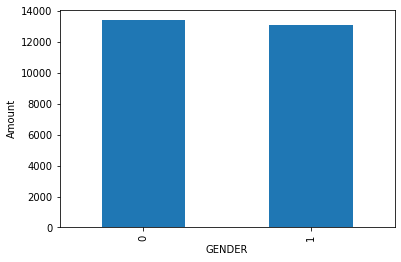

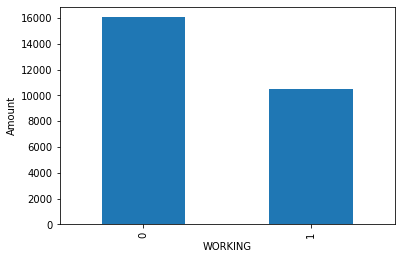

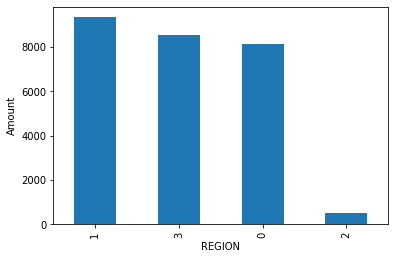

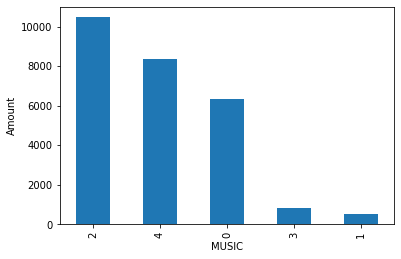

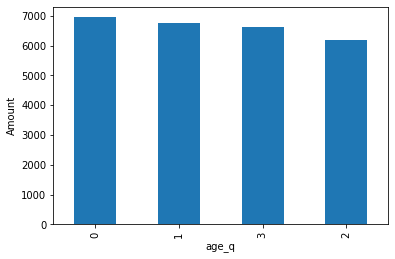

In [62]:
categorical_dist(catagorical)

In [68]:
def lmplot(df):
    df1 = df.drop(columns='Rating')
    for i in df1.columns:
        sns.lmplot(x=i, y='Rating', data=df)

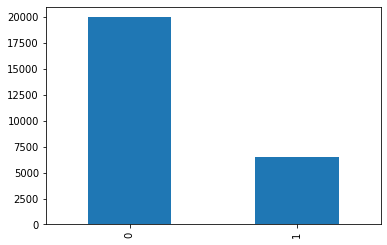

In [71]:
#CLASSES
merged_df['Rating'].value_counts().plot(kind='bar')

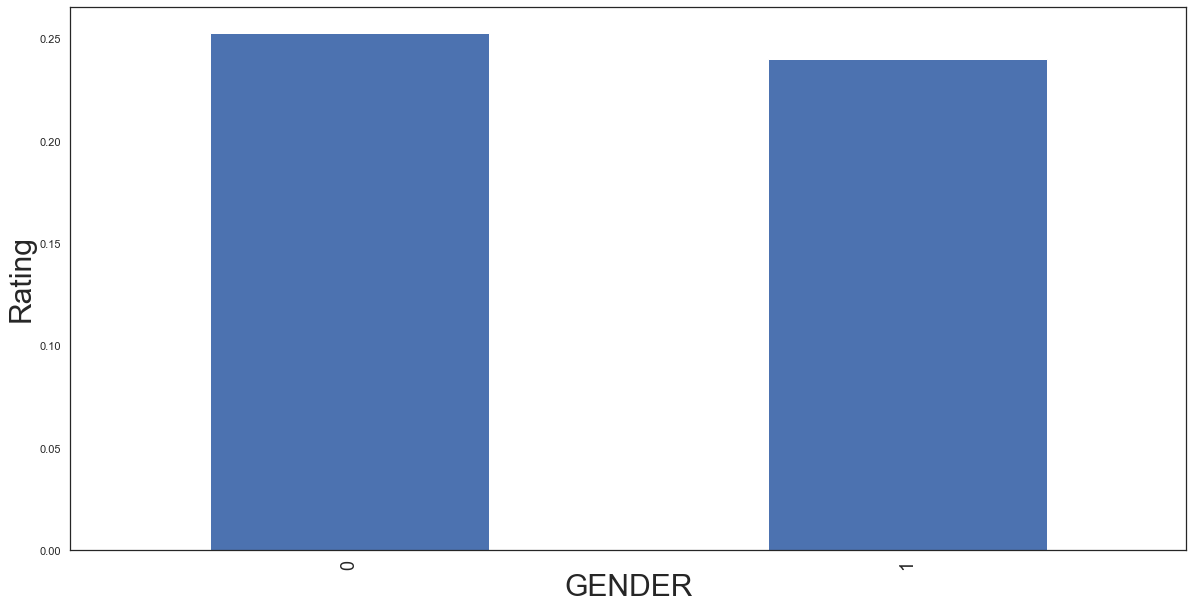

In [243]:
plt.figure(figsize=(20, 10))
plt.ylabel('Rating', fontsize=30)
plt.xlabel('GENDER', fontsize=30)
plt.xticks([0, 1], fontsize=18)
merged_df.groupby('GENDER')['Rating'].mean().plot(kind='bar')

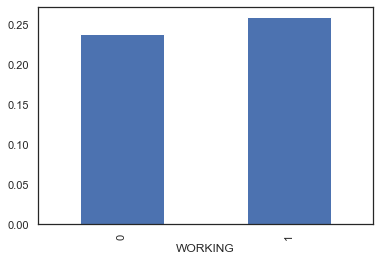

In [244]:
merged_df.groupby('WORKING')['Rating'].mean().plot(kind='bar')

# Feature Engineering

In [72]:
merged_df

,RESPID,GENDER,AGE,WORKING,REGION,MUSIC,Q1,Q2,Q3,Q4,...,Q15,Q16,Q17,Q18,Q19,Artist,Track,Rating,Time,age_q
1,3566,0,36.0,0,3,2,55.0,55.0,62.0,9.0,...,51.0,31.0,68.0,54.0,33.0,4,11,1,18,1
2,20054,0,52.0,1,0,0,11.0,50.0,9.0,8.0,...,27.0,46.0,73.0,8.0,31.0,25,59,0,21,3
3,41749,0,40.0,0,3,4,81.0,80.0,88.0,88.0,...,61.0,77.0,76.0,78.0,88.0,44,161,0,16,2
6,4596,0,58.0,0,1,0,31.0,31.0,37.0,78.0,...,10.0,14.0,49.0,29.0,24.0,2,7,0,18,3
7,40555,0,50.0,1,0,2,50.0,32.0,51.0,68.0,...,7.0,27.0,72.0,52.0,31.0,0,150,0,15,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47194,18269,0,46.0,1,3,2,10.0,62.0,47.0,31.0,...,31.0,10.0,32.0,10.0,10.0,21,48,0,21,2
47195,39239,1,24.0,1,1,0,45.0,6.0,44.0,71.0,...,32.0,32.0,49.0,29.0,30.0,6,149,0,15,0
47196,19361,1,48.0,0,0,0,9.0,73.0,33.0,6.0,...,12.0,10.0,50.0,10.0,28.0,21,48,0,21,2
47197,17639,0,60.0,0,0,4,26.0,50.0,49.0,58.0,...,30.0,6.0,73.0,20.0,21.0,25,59,0,21,3


In [109]:
#Dropping features to reduce model complexity
dropped_columns= ['Q4', 'Q6', 'Q19', 'Q11', 'Q10', 'Q12', 'Q14', 'Q13', 'Q15', 'Q16']

In [108]:
merged_df.columns

Index(['RESPID', 'GENDER', 'AGE', 'WORKING', 'REGION', 'MUSIC', 'Q1', 'Q2',
       'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13',
       'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Artist', 'Track', 'Rating',
       'Time', 'age_q'],
      dtype='object')

In [111]:
for col in dropped_columns:
    merged_df.drop(columns=col, inplace=True)
merged_df

,RESPID,GENDER,AGE,WORKING,REGION,MUSIC,Q1,Q2,Q3,Q5,Q7,Q8,Q9,Q17,Q18,Artist,Track,Rating,Time,age_q
1,3566,0,36.0,0,3,2,55.0,55.0,62.0,9.0,10.0,11.0,55.0,68.0,54.0,4,11,1,18,1
2,20054,0,52.0,1,0,0,11.0,50.0,9.0,45.0,30.0,29.0,8.0,73.0,8.0,25,59,0,21,3
3,41749,0,40.0,0,3,4,81.0,80.0,88.0,31.0,51.0,30.0,8.0,76.0,78.0,44,161,0,16,2
6,4596,0,58.0,0,1,0,31.0,31.0,37.0,58.0,82.0,13.0,70.0,49.0,29.0,2,7,0,18,3
7,40555,0,50.0,1,0,2,50.0,32.0,51.0,69.0,33.0,31.0,54.0,72.0,52.0,0,150,0,15,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47194,18269,0,46.0,1,3,2,10.0,62.0,47.0,32.0,49.0,32.0,62.0,32.0,10.0,21,48,0,21,2
47195,39239,1,24.0,1,1,0,45.0,6.0,44.0,70.0,5.0,8.0,70.0,49.0,29.0,6,149,0,15,0
47196,19361,1,48.0,0,0,0,9.0,73.0,33.0,10.0,51.0,52.0,93.0,50.0,10.0,21,48,0,21,2
47197,17639,0,60.0,0,0,4,26.0,50.0,49.0,59.0,6.0,5.0,88.0,73.0,20.0,25,59,0,21,3


In [91]:
#Function to dummify columns
def dummify(df, column):
    return pd.get_dummies(df[column])

In [262]:
#All dummified column
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
region_dum = dummify(merged_df, 'REGION')
working_dum = dummify(merged_df, 'WORKING')
music_dum = dummify(merged_df, 'MUSIC')
age_dummy = dummify(merged_df, 'age_q')

In [290]:
#Rename dummy list
region_dum.rename(columns={0 : 'Region 1', 1 : 'Region 2', 2 : 'Region 3', 3 : 'Region 4'}, inplace=True)
working_dum.rename(columns={0 : 'Working ', 1 : 'Not Working', 2 : 'Working 3', 3 : 'Working 4', 4 : 'Music 5'}, inplace=True)
music_dum.rename(columns={0 : 'Like Music', 1 : 'No Interest', 2 : 'Important', 3 : 'Kinda Important', 4 : 'Passionate '}, inplace=True)
age_dummy.rename(columns={0 : 'Age 13, 25', 1 : 'Age 25,39', 2 : 'Age 39,51',  3 : 'Age 51,89'}, inplace=True)

In [291]:
dummy_list = [region_dum, working_dum, music_dum, age_dummy]

Index(['Region 1', 'Region 2', 'Region 3', 'Region 4'], dtype='object')

In [294]:
merged_df_region = pd.concat([merged_df, dummy_list[0]], axis=1)
merged_df_working = pd.concat([merged_df, dummy_list[1]], axis=1)
merged_df_music = pd.concat([merged_df, dummy_list[2]], axis=1)
merged_df_age = pd.concat([merged_df, dummy_list[3]], axis=1)
master_df_dummy = pd.concat([merged_df, dummy_list[0], dummy_list[1],dummy_list[2], dummy_list[3]],axis=1)

RESPID       int64
GENDER       int64
AGE          int64
WORKING      int64
REGION       int64
MUSIC        int64
Q1         float64
Q2         float64
Q3         float64
Q5         float64
Q7         float64
Q8         float64
Q9         float64
Q17        float64
Q18        float64
Artist       int64
Track        int64
Rating       int64
Time         int64
age_q        int64
dtype: object

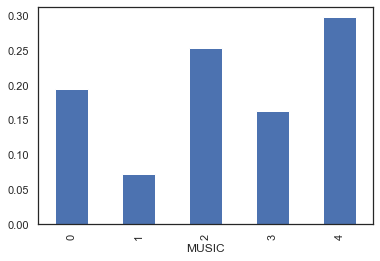

In [330]:
merged_df_music.groupby('MUSIC')['Rating'].mean().plot(kind='bar')

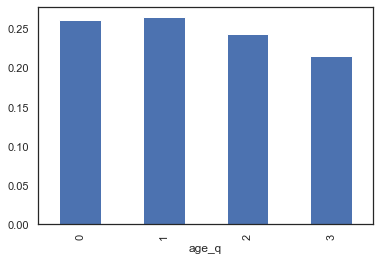

In [331]:
merged_df_age.groupby('age_q')['Rating'].mean().plot(kind='bar')

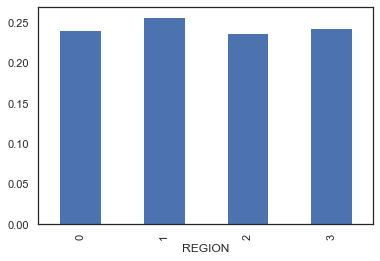

In [333]:
merged_df_region.groupby('REGION')['Rating'].mean().plot(kind='bar')

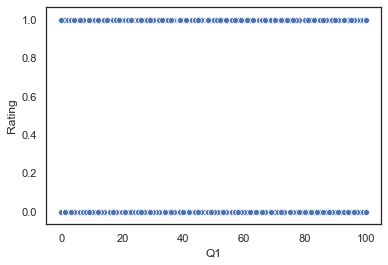

In [335]:
sns.scatterplot('Q1', 'Rating', data=merged_df)

In [336]:
master_df_dummy.corr()

,RESPID,GENDER,AGE,WORKING,REGION,MUSIC,Q1,Q2,Q3,Q5,...,Working 2,Music 1,Muisc 2,Music 3,Music 4,Music 5,Age 1,Age 2,Age 3,Age 4
RESPID,1.000000,0.005701,0.003696,0.021493,-0.011421,0.000616,0.013190,0.007438,0.016252,0.012371,...,0.021493,0.003270,0.000018,-0.004989,-0.009283,0.005740,-0.019868,0.017150,0.004945,-0.001930
GENDER,0.005701,1.000000,0.007905,0.189947,-0.010051,0.052868,0.107461,0.062448,0.087427,-0.000868,...,0.189947,-0.028998,0.037533,-0.042839,-0.021207,0.068221,-0.003797,-0.002598,-0.003114,0.009523
AGE,0.003696,0.007905,1.000000,-0.017756,-0.028582,-0.236896,-0.331269,-0.267730,-0.361855,-0.061116,...,-0.017756,0.185875,0.067106,-0.006254,0.088569,-0.217501,-0.739741,-0.224629,0.212255,0.770683
WORKING,0.021493,0.189947,-0.017756,1.000000,-0.023072,0.038034,0.052614,0.042249,0.051745,0.031439,...,1.000000,-0.033514,-0.017961,0.012256,-0.023943,0.032295,-0.211362,0.261917,0.135405,-0.181617
REGION,-0.011421,-0.010051,-0.028582,-0.023072,1.000000,0.018155,0.024322,0.012234,0.019661,-0.001332,...,-0.023072,-0.014964,-0.006693,0.002521,-0.007446,0.015899,0.063899,-0.043362,-0.027610,0.005767
MUSIC,0.000616,0.052868,-0.236896,0.038034,0.018155,1.000000,0.509780,0.380359,0.554672,0.021679,...,0.038034,-0.809307,-0.112223,-0.089606,0.100703,0.832127,0.173617,0.056290,-0.052113,-0.182231
Q1,0.013190,0.107461,-0.331269,0.052614,0.024322,0.509780,1.000000,0.614077,0.781539,0.119530,...,0.052614,-0.391152,-0.183023,0.011761,-0.173748,0.467110,0.250334,0.065418,-0.068604,-0.253277
Q2,0.007438,0.062448,-0.267730,0.042249,0.012234,0.380359,0.614077,1.000000,0.639211,-0.037799,...,0.042249,-0.280491,-0.193133,0.018540,-0.157931,0.355671,0.183948,0.067607,-0.044975,-0.211119
Q3,0.016252,0.087427,-0.361855,0.051745,0.019661,0.554672,0.781539,0.639211,1.000000,0.115485,...,0.051745,-0.427681,-0.200709,0.019328,-0.201448,0.508431,0.265926,0.082329,-0.073060,-0.281812
Q5,0.012371,-0.000868,-0.061116,0.031439,-0.001332,0.021679,0.119530,-0.037799,0.115485,1.000000,...,0.031439,-0.023727,-0.076962,0.043908,-0.013491,0.004013,0.032370,0.033893,-0.018782,-0.048695


In [341]:
cont_features = ['Q1', 'Q2',
       'Q3', 'Q5', 'Q7', 'Q8', 'Q9', 'Q17', 'Q18']

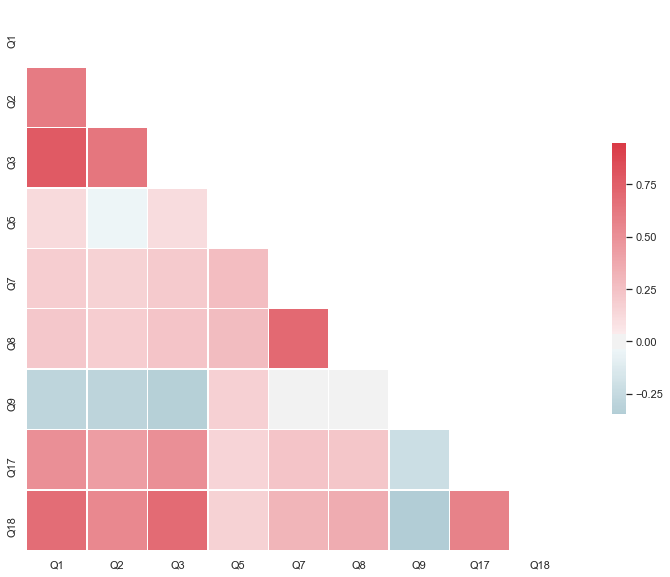

In [343]:
plt.figure(figsize=(15,10))

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(master_df_dummy[cont_features].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(master_df_dummy[cont_features].corr(), mask=mask, cmap=cmap, vmax=.95, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Model Fitting and Hyperparameter Tuning

## #KNN

In [302]:
#X and Y from DF
def x_y(df):
    X = df.drop(columns=['Rating'], axis=1)
    y = df['Rating']
    return X, y

In [303]:
# X = merged_df.drop(columns=['Rating'], axis = 1)
# y = merged_df['Rating']

In [304]:
#ALL DUMMY VARIABLES
X, y = x_y(master_df_dummy)

In [328]:
#TTS WITH CERTAIN DUMMY VARIABLES
music_x, music_y = x_y(merged_df_music)
region_x, region_y = x_y(merged_df_region)
age_x, age_y = x_y(merged_df_age)

In [305]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [306]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [307]:
#KNN GRIDSEARCH
def knn_grid(x_train, y_train, n = [3, 5], cv=0, n_jobs=-1):
    from sklearn.model_selection import GridSearchCV

    grid_params = {'n_neighbors' : n,
                   'weights' : ['uniform', 'distance'],
                   'metric' : ['euclidean', 'manhattan']

    }

    gs = GridSearchCV(KNeighborsClassifier(),
                      grid_params,
                      verbose = 1,
                      cv = 5,
                      n_jobs = n_jobs,
                      scoring='f1')
    gs_results = gs.fit(X_train, y_train)
    
    print('Best Parameters : ', gs_results.best_params_)
    print('Best F1 Score: ', gs_results.best_score_)

###  KNN BEST SCORE + RESULTS

In [308]:
knn_grid(X_train, y_train, n=[3,5,7], cv =3)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.8min finished


Best Parameters :  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best F1 Score:  0.26913050971982894


In [ ]:
knn_grid(music_x, music_y, n=[3,5,7], cv =3)

## Random Forest

In [309]:
#GRIDSEARCH RANDOM FOREST
def random_forest_grid(X_train, X_test, y_train, y_test,estimators=[400,500], depth=[], features=[], cv=0):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.dummy import DummyClassifier
    from sklearn.metrics import accuracy_score, f1_score

    param_grid = { 
    'n_estimators': estimators,
    'max_depth': depth,
    'criterion': ['entropy', 'gini'],
    'max_features' : features
}
    #create a grid search object and fit it to the data
    CV_rfc = GridSearchCV(RandomForestClassifier(), param_grid=param_grid,verbose=1, cv=cv,n_jobs=-1, scoring= 'f1')
    CV_rfc.fit(X_train, y_train)
    
    ### Identify the best params 
    print(CV_rfc.best_params_)


    #Identify the best score during fitting with cross-validation
    print(CV_rfc.best_score_)
    #predict on the test set

    rfc_pred = CV_rfc.best_estimator_.predict(X_test)
    # checking accuracy
    print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred))


    # checking accuracy
    print('Test F1 score: ', f1_score(y_test, rfc_pred))

### Random Forest Best Results

In [310]:
random_forest_grid(X_train, X_test, y_train, y_test, estimators=[400,450,500],depth=[3,4,5], features=[10,15,20], cv=3)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 11.9min finished


{'criterion': 'gini', 'max_depth': 5, 'max_features': 20, 'n_estimators': 400}
0.09997178696654335
Test Accuracy score:  0.7686162194754296
Test F1 score:  0.1361845807540799


In [ ]:
random_forest_grid(music_x, music, y_train, y_test, estimators=[300,350,400],depth=[3,4,5], features=[10,15,20], cv=3)

##  XGBOOST

In [315]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.3, 
                           subsample = 0.5,
                           learning_rate = .01,
                           max_depth = 3, 
                           alpha = 1, 
                           #scale_pos_weight= titanic['Survived'].mean(),
                           n_estimators = 500)

In [316]:
xg_clf.fit(X_train,y_train)

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [317]:
preds = xg_clf.predict(X_test)


test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.768013
F1: 0.137815


In [318]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

In [319]:
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import f1_score

In [325]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': [500,550,600],
              'learning_rate': [0.07,0.05],
              'max_depth': [3, 4, 5],
              'colsample_bytree': [0.5,0.45]
             }

In [326]:
gsearch1 = GridSearchCV(
    estimator = clf_xgb,
    param_grid = param_dist, 
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    iid=False, 
    cv=5)

In [327]:
gsearch1.fit(X,y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 37.1min finished
/Users/grayangelo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.45],
                         'learning_rate': [0.07, 0.05], 'max_depth': [3, 4, 5],
                         'n_estimators': [500, 5

### XGBOOST Best Results

In [323]:
gsearch1.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.07,
 'max_depth': 5,
 'n_estimators': 500}

In [324]:
gsearch1.best_score_

0.3093182881637747

In [215]:
# #GRIDSEARCH RANDOM FOREST
# def random_forest_grid(X_train, X_test, y_train, y_test,estimators=[400,500], depth=[], features=[], cv=0):
#     from sklearn.ensemble import RandomForestClassifier
#     from sklearn.dummy import DummyClassifier
#     from sklearn.metrics import accuracy_score, f1_score

#     param_grid = { 
#     'n_estimators': estimators,
#     'max_depth': depth,
#     'criterion': ['entropy', 'gini'],
#     'max_features' : features
# }
#     #create a grid search object and fit it to the data
#     CV_rfc = GridSearchCV(RandomForestClassifier(), param_grid=param_grid,verbose=1, cv=cv,n_jobs=-1, scoring= 'f1')
#     CV_rfc.fit(X_train, y_train)
    
#     ### Identify the best params 
#     print(CV_rfc.best_params_)


#     #Identify the best score during fitting with cross-validation
#     print(CV_rfc.best_score_)
#     #predict on the test set

#     rfc_pred = CV_rfc.best_estimator_.predict(X_test)
#     # checking accuracy
#     print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred))


#     # checking accuracy
#     print('Test F1 score: ', f1_score(y_test, rfc_pred))